In [1]:
import pandas as pd
from darts.models import TCNModel
from darts import TimeSeries
from darts.metrics.metrics import mae, rmse
from darts.utils.callbacks import TFMProgressBar
import logging
import warnings

from tfg_module import my_get_time_series as mgts

In [2]:
logging.getLogger('pytorch_lightning').setLevel(logging.CRITICAL)
warnings.filterwarnings('ignore')
prog_bar = TFMProgressBar(enable_train_bar = False, 
                          enable_prediction_bar = False,
                          enable_validation_bar = False,
                          enable_sanity_check_bar = False)

In [3]:
model_name = 'TCN'
TARGET = 'Ventas' # target can be either Ventas or Compras

In [4]:
ts = mgts.get_ts(TARGET)
ts

,date,Ventas
0,2017-09-30,"5,783"
1,2017-10-31,"20,854"
2,2017-11-30,"14,191"
3,2017-12-31,"7,595"
4,2018-01-31,"12,358"
...,...,...
72,2023-09-30,"16,520"
73,2023-10-31,"17,195"
74,2023-11-30,"13,819"
75,2023-12-31,"21,319"


In [5]:
ts = TimeSeries.from_dataframe(ts, time_col='date', value_cols=[TARGET])

In [6]:
split_train_test_index = int(len(ts) * 0.8)

train = ts[:split_train_test_index]
test = ts[split_train_test_index:]

In [7]:
model_name = "TCN_model"
tcn_model = TCNModel(
    input_chunk_length=7,
    output_chunk_length=3,
)

In [8]:
params_grid = dict(input_chunk_length = [4,8,12], 
                    output_chunk_length = [1, 2, 3],
                    n_epochs = [10],
                    dropout = [0.2],
                    dilation_base = [2],
                    weight_norm = [True],
                    kernel_size = [3],
                    num_filters = [6],
                    random_state = [0],
                    batch_size = [32], 
                    pl_trainer_kwargs=[{"callbacks": [prog_bar]}])
                           


In [9]:
best_tcn_mae_model = tcn_model.gridsearch(parameters=params_grid, 
                                          series= train, val_series= test, 
                                          metric=mae)

In [10]:
best_tcn_rmse_model = tcn_model.gridsearch(parameters=params_grid, 
                                          series= train, val_series= test,
                                          metric=rmse)

In [11]:
modelos = {'best_MAE':best_tcn_mae_model, 'best_RMSE': best_tcn_rmse_model}
models_by_metric = {}
for metrica, MODELO in modelos.items():
    best_score = MODELO[2]
    best_model = MODELO[0]
    best_model.fit(train, val_series = test, verbose = False)
    best_params = MODELO[1]
    if metrica == 'best_MAE':
        rmse_in_mae_model = rmse(best_tcn_mae_model[0].predict(n =len(test), series = train), test)
        models_by_metric[metrica] = (best_model, best_params, best_score, rmse_in_mae_model)
    else:
        mae_in_rmse_model = mae(best_tcn_rmse_model[0].predict(n =len(test), series = train), test)
        models_by_metric[metrica] = (best_model, best_params, mae_in_rmse_model, best_score)
        
best_tcn_models_df = pd.DataFrame(models_by_metric)
best_tcn_models_df.index = ['model', 'parameters', 'mae', 'rmse']

En TCN de darts, no se puede monitorizar dos métricas en un mismo entrenamiento de gridsearch. Por tant, se hacen dos entrenamientos: uno monitorizando `MAE` y otro `RMSE`. Puede darse el caso de que la medida `MAE` obtenida en el entrenamiento de `MSE` (o viceversa) sea incluso mejor a `best_score` obtenido en el entrenamiento de `MAE` (o viceversa).

In [12]:
best_tcn_models_df

,best_MAE,best_RMSE
model,"TCNModel(num_filters=6, weight_norm=True, inpu...","TCNModel(num_filters=6, weight_norm=True, inpu..."
parameters,"{'input_chunk_length': 4, 'output_chunk_length...","{'input_chunk_length': 4, 'output_chunk_length..."
mae,"3,181","3,174"
rmse,"4,530","4,499"


In [13]:
best_mae_model = best_tcn_models_df.loc['model','best_MAE']
best_mae_model

TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=6, num_layers=None, dilation_base=2, weight_norm=True, dropout=0.2, input_chunk_length=4, output_chunk_length=3, n_epochs=10, random_state=0, batch_size=32, pl_trainer_kwargs={'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x00000210E28881A0>]})

<Axes: xlabel='date'>

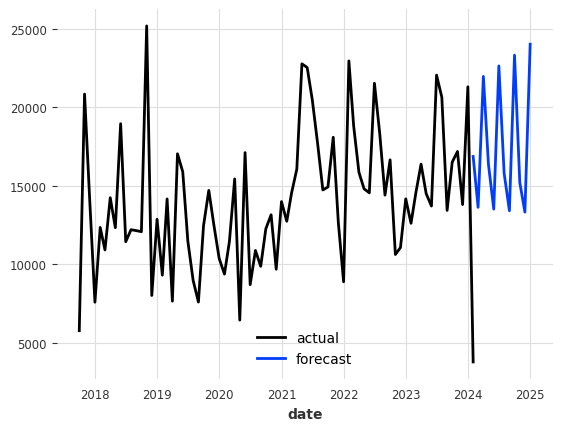

In [14]:
predictions = best_mae_model.predict(n= 12, series = ts[:-1])
ts.plot(label = 'actual')
predictions.plot(label = 'forecast')

In [15]:
best_mae_df = predictions.pd_dataframe()
best_mae_df.columns.name = None
best_mae_df.reset_index(inplace = True)
best_mae_df

,date,Ventas
0,2024-01-31,"16,880"
1,2024-02-29,"13,639"
2,2024-03-31,"21,980"
3,2024-04-30,"16,364"
4,2024-05-31,"13,525"
5,2024-06-30,"22,648"
6,2024-07-31,"15,810"
7,2024-08-31,"13,424"
8,2024-09-30,"23,331"
9,2024-10-31,"15,218"


In [16]:
best_rmse_model = best_tcn_models_df.loc['model','best_RMSE']
best_rmse_model

TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=6, num_layers=None, dilation_base=2, weight_norm=True, dropout=0.2, input_chunk_length=4, output_chunk_length=3, n_epochs=10, random_state=0, batch_size=32, pl_trainer_kwargs={'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x00000210E27EFF20>]})

<Axes: xlabel='date'>

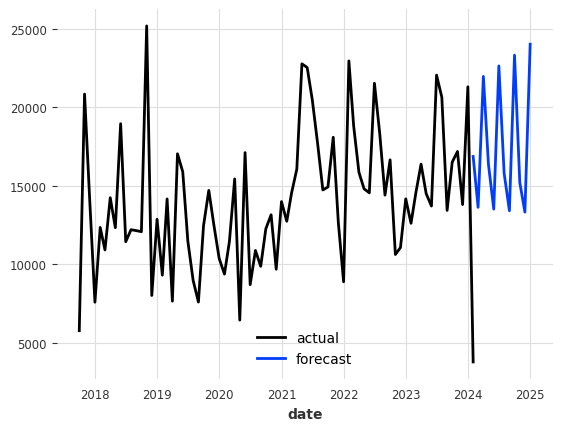

In [17]:
predictions = best_rmse_model.predict(n= 12, series = ts[:-1])
ts.plot(label = 'actual')
predictions.plot(label = 'forecast')

In [18]:
best_rmse_df = predictions.pd_dataframe()
best_rmse_df.columns.name = None
best_rmse_df.reset_index(inplace = True)
best_rmse_df

,date,Ventas
0,2024-01-31,"16,880"
1,2024-02-29,"13,639"
2,2024-03-31,"21,980"
3,2024-04-30,"16,364"
4,2024-05-31,"13,525"
5,2024-06-30,"22,648"
6,2024-07-31,"15,810"
7,2024-08-31,"13,424"
8,2024-09-30,"23,331"
9,2024-10-31,"15,218"
